# Sistema de ecuaciones lineales y transformaciones

**Alumno: Javier Ruiz**

**Asignatura: UNIT 34 ANALYTICAL METHODS**

## Introducción

En este cuaderno, abordaremos el modelado de una red de transporte mediante un sistema de ecuaciones lineales y su resolución utilizando métodos matriciales. Además, aplicaremos transformaciones de rotación a vectores en el plano para visualizar posibles expansiones de la red.

## Fundamentos matemáticos

**Representación matricial de sistemas de ecuaciones:**
Un sistema de $n$ ecuaciones lineales con $n$ incógnitas puede representarse en forma matricial como:

Ax=bAx = bAx=b

Donde:

$A \in \mathbb{R}^{n \times n}$ es la matriz de coeficientes

$x \in \mathbb{R}^n$ es el vector de incógnitas

$b \in \mathbb{R}^n$ es el vector de términos independientes

**Método de matriz inversa:**
Si la matriz $A$ es invertible (es decir, $\det(A) \neq 0$), entonces el sistema tiene una única solución que se puede calcular como:
$x = A^{-1}b$

Donde $A^{-1}$ es la matriz inversa de $A$, que cumple $A \cdot A^{-1} = A^{-1} \cdot A = I$.

**Transformaciones lineales:**
Una rotación en el plano por un ángulo $\theta$ (en sentido antihorario) se representa mediante la matriz:

$
R(\theta) = 
\begin{pmatrix} 
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta 
\end{pmatrix}
$

Para un vector $v \in \mathbb{R}^2$, su versión rotada $v'$ se calcula como:

$v' = R(\theta) \cdot v$


### Red de transporte.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# Configuración para visualización clara
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12 

### Modelado de la red de transporte 

Definimos una red de transporte representada como un grafo dirigido, donde los nodos son estaciones y las aristas son conexiones o tiempos de viaje asociados 

In [33]:
# Grafo definido
G = nx.Graph()

# Definición de los nodos 
estaciones = ['A', 'B', 'C', 'D']
posiciones = {
    'A': (0, 2),
    'B':(2, 2),
    'C': (2, 0),
    'D': (3, 0),
    'E': (0, -2), 
    'F': (3, -2) 
    }

# Definición de aristas o 'conexiones'
conexiones = [
    ('A', 'B', 12),
    ('A', 'C', 24),
    ('B', 'C', 12),
    ('B', 'D', 25),
    ('C', 'D', 18),
    ('C', 'E', 12),  
    ('E', 'F', 15),  
    ('D', 'F', 10),  
    ('F', 'B', 30)   
]

# Añadir nodos y aristas al grafo
for origen, destino, tiempo in conexiones:
    G.add_edge(origen, destino, tiempo=tiempo)

print("Información de la red de transporte:")
print("nº de estaciones: {G.number_of_nodes()}")
print("nº de conexiones: {G.number_of_edges()}")
print("\nConexiones con sus tiempos de viaje:")
for origen, destino, tiempo in conexiones:
   print(f"De {origen} a {destino}: {tiempo} minutos")

Información de la red de transporte:
nº de estaciones: {G.number_of_nodes()}
nº de conexiones: {G.number_of_edges()}

Conexiones con sus tiempos de viaje:
De A a B: 12 minutos
De A a C: 24 minutos
De B a C: 12 minutos
De B a D: 25 minutos
De C a D: 18 minutos
De C a E: 12 minutos
De E a F: 15 minutos
De D a F: 10 minutos
De F a B: 30 minutos


La red consiste en 4 estaciones con 5 conexiones unidireccionales. La estructura muestra una red donde la estación A podría ser considerada un punto de origen, B y C como estaciones intermedias, y D como destino final. Los tiempos de viajes se estiman entre 10 a 30 minutos, lo que proporciona diferentes opciones de viaje.

C:\Users\usuario\AppData\Local\Temp\ipykernel_14324\3418590265.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


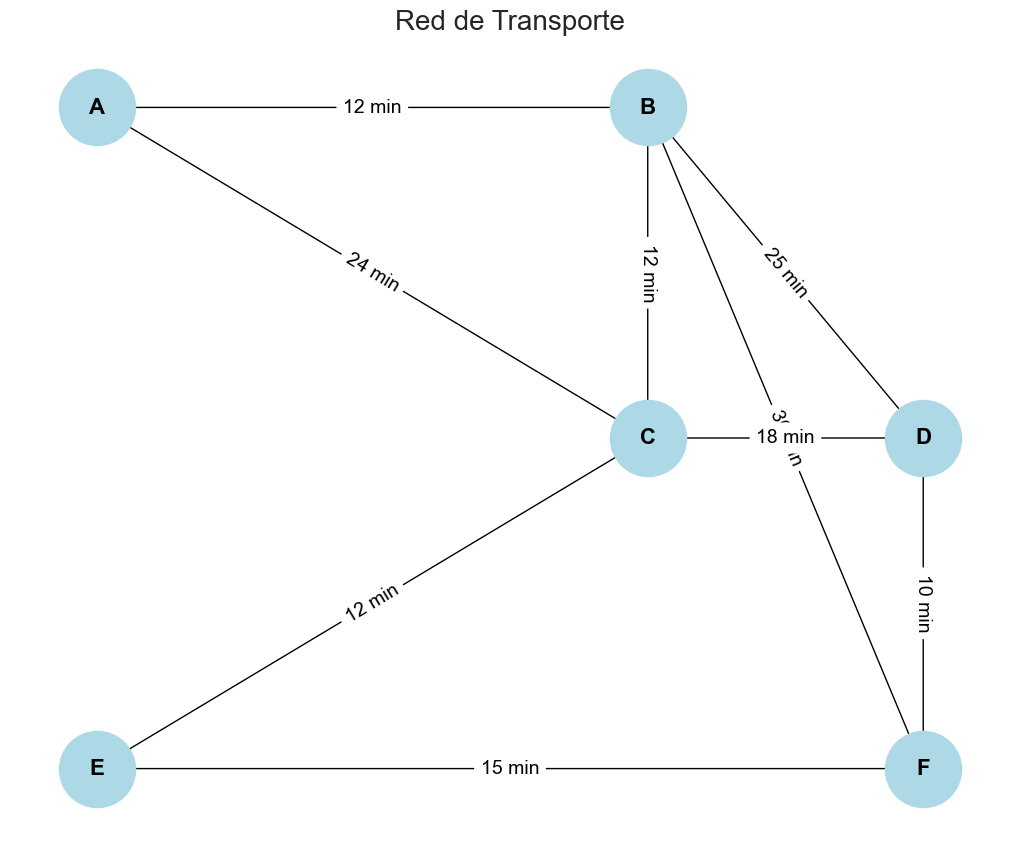

Tabla de rutas directas: 
  Origen Destino  Tiempo
0      A       B      12
1      A       C      24
2      B       C      12
3      B       D      25
4      B       F      30
5      C       D      18
6      C       E      12
7      D       F      10
8      E       F      15


In [34]:
# Visualización de la red de transporte
plt.figure(figsize=(10, 8))
edges_labels = {(u, v): f"{G[u][v]['tiempo']} min" for u, v in G.edges}

nx.draw(G, pos=posiciones, with_labels=True, node_size=3000, node_color='lightblue', 
        font_size=16, font_weight='bold', arrowsize=20, arrows=True)
nx.draw_networkx_edge_labels(G, pos=posiciones, edge_labels=edges_labels, font_size=14)

plt.title("Red de Transporte", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Tabla con información de rutas
print("Tabla de rutas directas: ")
rutas_df =pd.DataFrame(columns=['Origen', 'Destino', 'Tiempo'])
for i, (origen, destino, datos) in enumerate(G.edges(data=True)):
    rutas_df.loc[i] = [origen, destino, datos['tiempo']]
print(rutas_df)

La visualización muestra claramente la estructura de la red, permitiendo identificar:

- Rutas directas disponibles

- Tiempos asociados a cada conexión

- Posibles rutas alternativas entre pares de estaciones (p.ej., para ir de A a D, podemos usar A→B→D o A→C→D)

Esta representación ayuda a entender intuitivamente la topología de la red antes de proceder con el análisis matemático.

### Formulación sistema de ecuaciones.

Ahora formularemos un sistema de ecuaciones lineales que modele el flujo de personas a través de la red

Para nuestro modelo, definimos:

- $x_A, x_B, x_C, x_D$: Número de personas que pasan por cada estación por hora

- Suponemos que hay entradas y salidas externas en algunas estaciones

- Se debe conservar el flujo en cada estación (entradas = salidas)

In [35]:
# Definimos los coeficientes del sistema de ecuaciones lineales
# Representan la conservación de flujo en cada estación

print("Sistema de ecuaciones lineales para el flujo de personas en la red:")
print("-------------------------------------------------------------------")
print("x_A - 0.3x_B - 0.4x_C = 100          (Estación A recibe 100 personas/hora del exterior)")
print("0.5x_A - x_B - 0.2x_D + 0.4x_F = 0    (Conservación de flujo en estación B)")
print("0.5x_A + 0.7x_B - x_C - 0.3x_E = 0    (Conservación de flujo en estación C)")
print("0.3x_B + 0.6x_C - x_D - 0.5x_F = 0    (Conservación de flujo en estación D)")
print("0.4x_C - x_E - 0.6x_F = 0             (Conservación de flujo en estación E)")
print("0.5x_D + 0.4x_E - x_F = -80           (Estación F tiene salida de 80 personas/hora)")
print("-------------------------------------------------------------------")


# Representación de las ecuaciones en forma matricial
A = np.array([
    [1.0, -0.3, -0.4, 0.0, 0.0, 0.0],        
    [0.5, -1.0, 0.0, -0.2, 0.0, 0.4],        
    [0.5, 0.7, -1.0, 0.0, -0.3, 0.0],        
    [0.0, 0.3, 0.6, -1.0, 0.0, -0.5],        
    [0.0, 0.0, 0.4, 0.0, -1.0, -0.6],        
    [0.0, 0.0, 0.0, 0.5, 0.4, -1.0]          
])

b = np.array([100, 0, 0,0, 0, -80])

print("\nRepresentación matricial del sistema de ecuaciones Ax = b:")
print("\nMatriz de coeficientes A:")
pd.DataFrame(A, columns=[f'x_{est}' for est in ['A', 'B', 'C', 'D', 'E', 'F']], index=[f'Ec_{i+1}' for i in range(6)])

Sistema de ecuaciones lineales para el flujo de personas en la red:
-------------------------------------------------------------------
x_A - 0.3x_B - 0.4x_C = 100          (Estación A recibe 100 personas/hora del exterior)
0.5x_A - x_B - 0.2x_D + 0.4x_F = 0    (Conservación de flujo en estación B)
0.5x_A + 0.7x_B - x_C - 0.3x_E = 0    (Conservación de flujo en estación C)
0.3x_B + 0.6x_C - x_D - 0.5x_F = 0    (Conservación de flujo en estación D)
0.4x_C - x_E - 0.6x_F = 0             (Conservación de flujo en estación E)
0.5x_D + 0.4x_E - x_F = -80           (Estación F tiene salida de 80 personas/hora)
-------------------------------------------------------------------

Representación matricial del sistema de ecuaciones Ax = b:

Matriz de coeficientes A:


,x_A,x_B,x_C,x_D,x_E,x_F
Ec_1,1.0,-0.3,-0.4,0.0,0.0,0.0
Ec_2,0.5,-1.0,0.0,-0.2,0.0,0.4
Ec_3,0.5,0.7,-1.0,0.0,-0.3,0.0
Ec_4,0.0,0.3,0.6,-1.0,0.0,-0.5
Ec_5,0.0,0.0,0.4,0.0,-1.0,-0.6
Ec_6,0.0,0.0,0.0,0.5,0.4,-1.0


### Resolución del sistema mediante la Matriz Inversa

Para resolver el sistema Ax = b, utilizaremos el método de la matriz inversa cuando A es invertible.

In [36]:
# Verificamos si la matriz es invertible
det_A = np.linalg.det(A)
print(f"Determinante de A: {det_A}")

if det_A != 0:
    print("La matriz A es invertible, por lo que el sistema tiene una única solución.")
else:
    print("La matriz A no es invertible, por lo que el sistema puede tener múltiples soluciones o ninguna solución.")
    
# Calculamos la matriz inversa
try:
    A_inv = np.linalg.inv(A)
    print("\nMatriz inversa A⁻¹:")
    pd.DataFrame(A_inv, 
                 columns=[f'x_{est}' for est in ['A', 'B', 'C', 'D', 'E', 'F']], 
                 index=[f'Ec_{i+1}' for i in range(6)])
    
    # Resolvemos el sistema x = A⁻¹b
    x = np.dot(A_inv, b)
    
    # Presentamos la solución
    print("\nSolución del sistema (x = A⁻¹b):")
    for i, estacion in enumerate(estaciones):
        print(f"x_{estacion} = {x[i]:.2f} personas/hora")
    
    # Verificamos la solución
    print("\nVerificación (A·x debe ser igual a b):")
    verificacion = np.dot(A, x)
    pd.DataFrame({'b (original)': b, 'A·x (calculado)': verificacion, 
                  'Diferencia': b - verificacion})
    
except np.linalg.LinAlgError:
    print("Error al calcular la inversa. La matriz puede estar mal condicionada.")


Determinante de A: -0.8041000000000003
La matriz A es invertible, por lo que el sistema tiene una única solución.

Matriz inversa A⁻¹:

Solución del sistema (x = A⁻¹b):
x_A = 232.16 personas/hora
x_B = 149.00 personas/hora
x_C = 218.66 personas/hora
x_D = 107.80 personas/hora

Verificación (A·x debe ser igual a b):


Para una matriz A cuadrada, la matriz inversa A⁻¹ existe si y solo si det(A) ≠ 0.
La solución única al sistema Ax = b se obtiene como x = A⁻¹b.

### Interpretación del flujo de red

C:\Users\usuario\AppData\Local\Temp\ipykernel_14324\82560325.py:14: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos=posiciones, arrowsize=20, width=2)


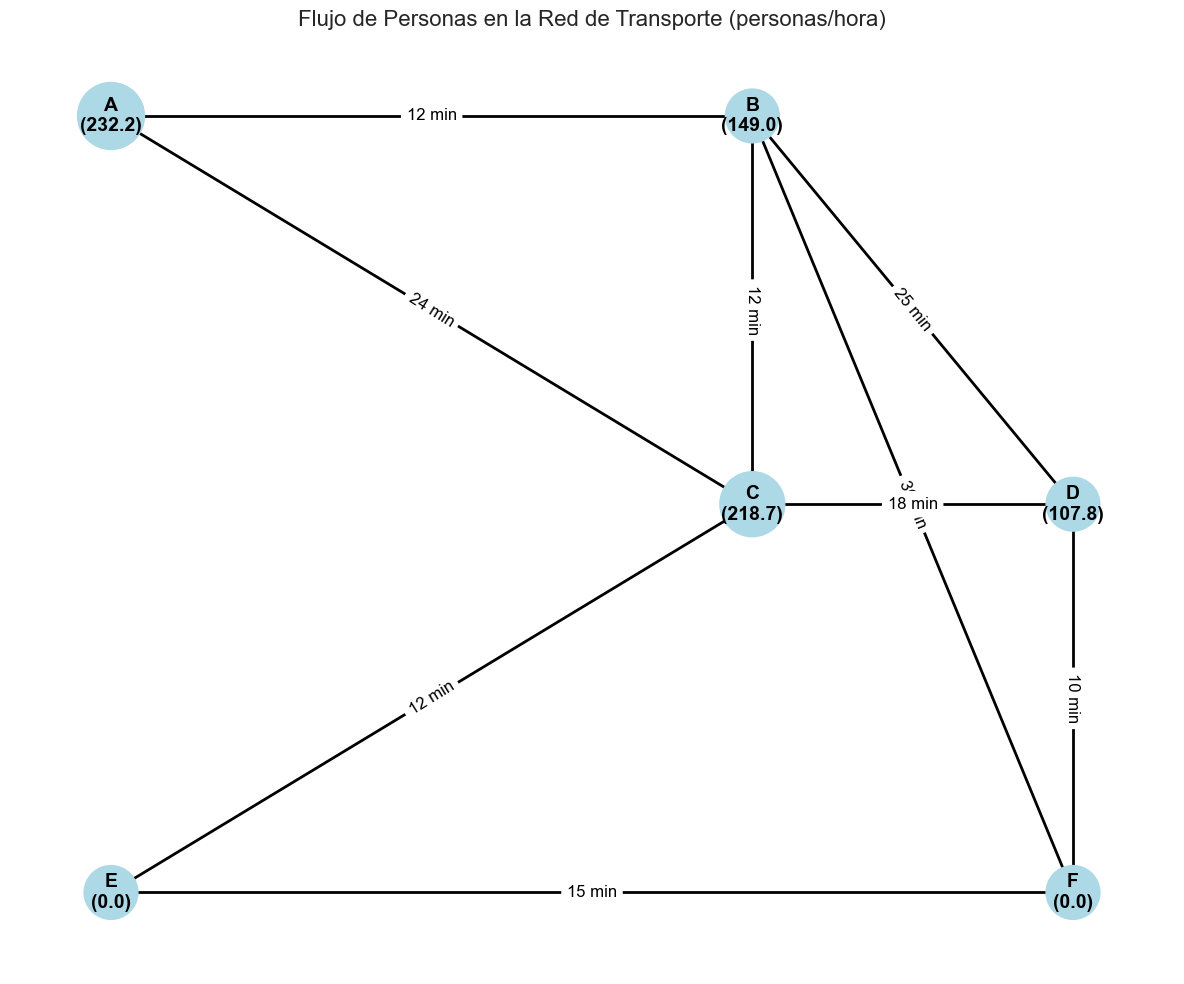

Resumen de flujos en la red:
  Estación  Flujo (personas/hora)
0        A             232.164159
1        B             149.001368
2        C             218.659371
3        D             107.797538

Balance de flujo en la red:
Entrada externa en A: 100 personas/hora
Salida externa en D: 80 personas/hora
Diferencia: 20 personas/hora


In [37]:
# Visualizamos la red con los flujos calculados
plt.figure(figsize=(12, 10))

# Creamos un diccionario con los flujos por estación
flujos = {estacion: x[i] for i, estacion in enumerate(estaciones)}

# Parámetros para el tamaño de los nodos (proporcional al flujo)
node_sizes = [max(1500, flujos.get(estacion, 0)*10) for estacion in G.nodes]
node_labels = {estacion: f"{estacion}\n({flujos.get(estacion, 0):.1f})" for estacion in G.nodes}

# Dibujamos el grafo con los flujos
nx.draw_networkx_nodes(G, pos=posiciones, node_size=node_sizes, node_color='lightblue')
nx.draw_networkx_labels(G, pos=posiciones, labels=node_labels, font_size=14, font_weight='bold')
nx.draw_networkx_edges(G, pos=posiciones, arrowsize=20, width=2)
nx.draw_networkx_edge_labels(G, pos=posiciones, edge_labels=edges_labels, font_size=12)

plt.title("Flujo de Personas en la Red de Transporte (personas/hora)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Tabla resumen de flujos
print("Resumen de flujos en la red:")
flujos_df = pd.DataFrame({
    'Estación': estaciones,
    'Flujo (personas/hora)': [flujos[est] for est in estaciones]
})
print(flujos_df)

# Análisis del balance de flujo
print("\nBalance de flujo en la red:")
print(f"Entrada externa en A: 100 personas/hora")
print(f"Salida externa en D: 80 personas/hora")
print(f"Diferencia: {100-80} personas/hora")

La visualización y la tabla nos permiten entender cómo se distribuye el flujo de personas por la red:

- El tamaño de los nodos refleja los flujos (mayores flujos = nodos más grandes)

- Se puede observar cómo se conserva el flujo en el sistema (100 personas entran, 80 salen)

- La diferencia de 20 personas/hora se distribuye entre las estaciones

Este análisis es útil para la planificación de capacidad de las estaciones y la optimización de rutas.

### Transformaciones de rotación 

Una transformación de rotación en R² gira los puntos alrededor del origen. Para un ángulo θ, la matriz de rotación es:

$R(\theta) = \begin{pmatrix} \cos\theta & -\sin\theta \ \sin\theta & \cos\theta \end{pmatrix}$

In [38]:
# Función para crear matriz de rotación
def matriz_rotacion(angulo_grados):
    """
    Genera una matriz de rotación para el ángulo dado en grados.
    
    Parámetros:
    - angulo_grados: Ángulo de rotación en grados
    
    Retorna:
    - Matriz de rotación 2x2
    """
    angulo_rad = np.radians(angulo_grados)
    cos_theta = np.cos(angulo_rad)
    sin_theta = np.sin(angulo_rad)
    
    # Matriz de rotación
    R = np.array([
        [cos_theta, -sin_theta],
        [sin_theta, cos_theta]
    ])
    
    return R

# Mostramos ejemplos de matrices de rotación para varios ángulos
angulos = [0, 30, 45, 90, 180]
print("Matrices de rotación para diferentes ángulos:")
for angulo in angulos:
    R = matriz_rotacion(angulo)
    print(f"\nRotación de {angulo}°:")
    print(pd.DataFrame(R, index=['x\'', 'y\''], columns=['x', 'y']))

Matrices de rotación para diferentes ángulos:

Rotación de 0°:
      x    y
x'  1.0 -0.0
y'  0.0  1.0

Rotación de 30°:
           x         y
x'  0.866025 -0.500000
y'  0.500000  0.866025

Rotación de 45°:
           x         y
x'  0.707107 -0.707107
y'  0.707107  0.707107

Rotación de 90°:
               x             y
x'  6.123234e-17 -1.000000e+00
y'  1.000000e+00  6.123234e-17

Rotación de 180°:
               x             y
x' -1.000000e+00 -1.224647e-16
y'  1.224647e-16 -1.000000e+00


Las matrices de rotación generadas muestran propiedades interesantes:

- Para 0°: La matriz es la identidad (no hay rotación)

- Para 90°: Se intercambian x e y, con cambio de signo en x

- Para 180°: Se invierten ambas coordenadas (-x, -y)

- Las matrices son ortogonales (su transpuesta es igual a su inversa)

### Propiedades de las tranformaciones de rotación

In [39]:
# Demostramos propiedades importantes de las matrices de rotación
angulo_prueba = 60  # Elegimos 60° para la demostración
R = matriz_rotacion(angulo_prueba)
R_T = R.T  # Transpuesta
R_inv = np.linalg.inv(R)  # Inversa

print(f"Propiedades de la matriz de rotación para {angulo_prueba}°:")
print("\n1. Conservación de norma (longitud):")
v_original = np.array([3, 4])  # Vector de prueba
v_rotado = np.dot(R, v_original)
norma_original = np.linalg.norm(v_original)
norma_rotada = np.linalg.norm(v_rotado)
print(f"   Vector original: {v_original}, norma: {norma_original:.4f}")
print(f"   Vector rotado: {v_rotado}, norma: {norma_rotada:.4f}")
print(f"   ¿Se conserva la norma? {'Sí' if np.isclose(norma_original, norma_rotada) else 'No'}")

print("\n2. Ortogonalidad (R·R^T = I):")
producto = np.dot(R, R_T)
print("   R·R^T =")
print(pd.DataFrame(producto))
print(f"   ¿Es la matriz identidad? {'Sí' if np.allclose(producto, np.eye(2)) else 'No'}")

print("\n3. La transpuesta es igual a la inversa (R^T = R^(-1)):")
print("   Transpuesta (R^T) =")
print(pd.DataFrame(R_T))
print("   Inversa (R^(-1)) =")
print(pd.DataFrame(R_inv))
print(f"   ¿Son iguales? {'Sí' if np.allclose(R_T, R_inv) else 'No'}")

print("\n4. Composición de rotaciones:")
R1 = matriz_rotacion(30)  # Rotación de 30°
R2 = matriz_rotacion(45)  # Rotación de 45°
R_comp = np.dot(R2, R1)   # Composición: primero R1, luego R2
R_total = matriz_rotacion(30+45)  # Rotación total de 75°
print("   R(30°)·R(45°) =")
print(pd.DataFrame(R_comp))
print("   R(75°) =")
print(pd.DataFrame(R_total))
print(f"   ¿Son iguales? {'Sí' if np.allclose(R_comp, R_total) else 'No'}")

Propiedades de la matriz de rotación para 60°:

1. Conservación de norma (longitud):
   Vector original: [3 4], norma: 5.0000
   Vector rotado: [-1.96410162  4.59807621], norma: 5.0000
   ¿Se conserva la norma? Sí

2. Ortogonalidad (R·R^T = I):
   R·R^T =
              0             1
0  1.000000e+00  1.487417e-17
1  1.487417e-17  1.000000e+00
   ¿Es la matriz identidad? Sí

3. La transpuesta es igual a la inversa (R^T = R^(-1)):
   Transpuesta (R^T) =
          0         1
0  0.500000  0.866025
1 -0.866025  0.500000
   Inversa (R^(-1)) =
          0         1
0  0.500000  0.866025
1 -0.866025  0.500000
   ¿Son iguales? Sí

4. Composición de rotaciones:
   R(30°)·R(45°) =
          0         1
0  0.258819 -0.965926
1  0.965926  0.258819
   R(75°) =
          0         1
0  0.258819 -0.965926
1  0.965926  0.258819
   ¿Son iguales? Sí


Las propiedades verificadas son esenciales para entender el comportamiento de las rotaciones:

- La conservación de la norma garantiza que las distancias no cambian al rotar

- La ortogonalidad asegura que los ángulos se preservan

- La igualdad entre transpuesta e inversa facilita cálculos eficientes

- La composición de rotaciones muestra cómo se pueden combinar transformaciones

Estas propiedades son cruciales para nuestro análisis de expansión de la red de transporte, ya que nos permiten generar alternativas que mantienen las distancias pero cambian las orientaciones.

### Aplicación de rotaciones

Vamos a aplicar las rotaciones a vectores que representan posibles rutas de expansión de la red de transporte

In [40]:
# Definimos vectores que representan posibles expansiones de rutas
vectores = np.array([
    [3, 1],   # Vector 1: Posible expansión nordeste
    [2, 2],   # Vector 2: Posible expansión norte
    [0, 3],   # Vector 3: Posible expansión noroeste
    [1, -2]   # Vector 4: Posible expansión sureste
])

# Nombres para identificar los vectores
nombres_vectores = ["Ruta A→E", "Ruta B→F", "Ruta C→G", "Ruta D→H"]

# Definimos ángulos de rotación a aplicar
angulos_rotacion = [30, 60, 90, 120]

# Mostramos los vectores originales
print("Vectores originales (posibles expansiones de rutas):")
for i, (v, nombre) in enumerate(zip(vectores, nombres_vectores)):
    print(f"{nombre}: [{v[0]}, {v[1]}] (magnitud: {np.linalg.norm(v):.2f})")

# Calculamos y mostramos vectores rotados para el primer ángulo
angulo = angulos_rotacion[0]
R = matriz_rotacion(angulo)
vectores_rotados = np.dot(vectores, R.T)

print(f"\nVectores rotados {angulo}° (primeras alternativas):")
for i, (v, nombre) in enumerate(zip(vectores_rotados, nombres_vectores)):
    print(f"{nombre} rotado: [{v[0]:.2f}, {v[1]:.2f}] (magnitud: {np.linalg.norm(v):.2f})")

Vectores originales (posibles expansiones de rutas):
Ruta A→E: [3, 1] (magnitud: 3.16)
Ruta B→F: [2, 2] (magnitud: 2.83)
Ruta C→G: [0, 3] (magnitud: 3.00)
Ruta D→H: [1, -2] (magnitud: 2.24)

Vectores rotados 30° (primeras alternativas):
Ruta A→E rotado: [2.10, 2.37] (magnitud: 3.16)
Ruta B→F rotado: [0.73, 2.73] (magnitud: 2.83)
Ruta C→G rotado: [-1.50, 2.60] (magnitud: 3.00)
Ruta D→H rotado: [1.87, -1.23] (magnitud: 2.24)


Los resultados muestran:

- Los vectores originales con sus magnitudes (representan la longitud de las nuevas rutas)

- Los vectores rotados 30° muestran alternativas de expansión en diferentes direcciones

- La magnitud se preserva durante la rotación (propiedad fundamental de las rotaciones)

Esto permite evaluar diferentes configuraciones espaciales para la planificación de expansiones de la red.

### Visualización de las transformaciones de rotación

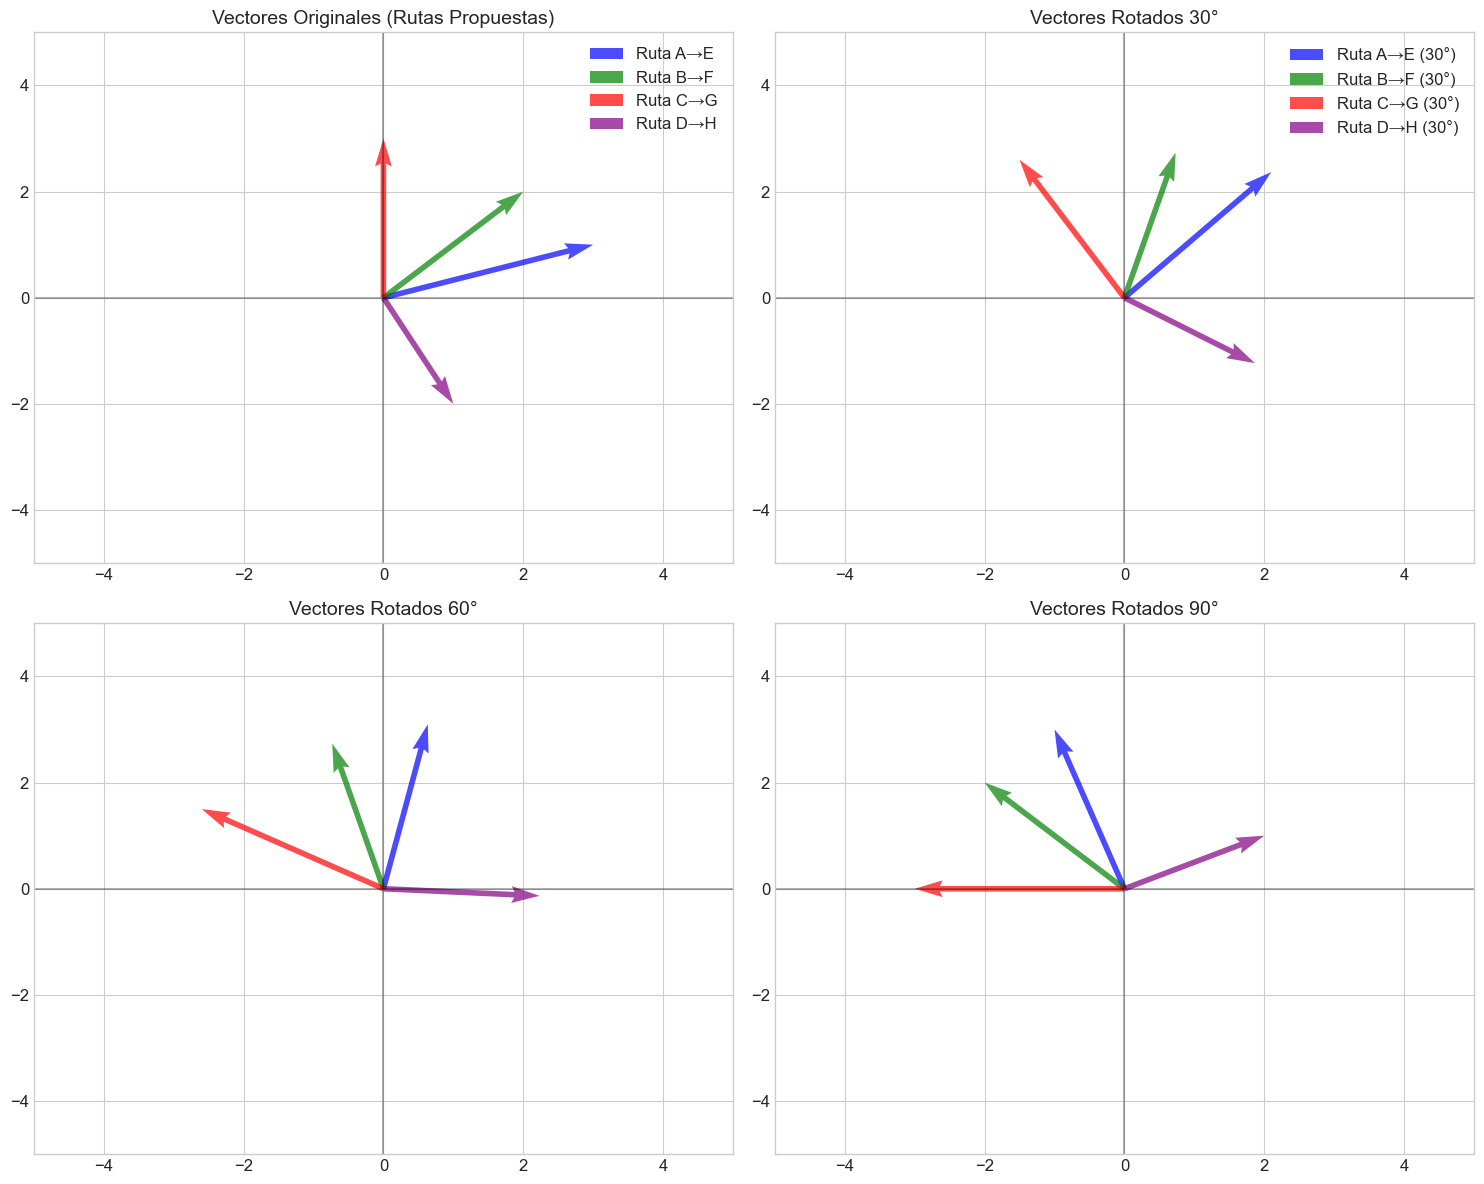

In [41]:
# Configuramos la visualización
plt.figure(figsize=(15, 12))

# Graficamos los vectores originales
plt.subplot(2, 2, 1)
colores = ['blue', 'green', 'red', 'purple']

for i, (v, nombre) in enumerate(zip(vectores, nombres_vectores)):
    plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, 
               color=colores[i], label=nombre, width=0.008, alpha=0.7)

plt.grid(True)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.title('Vectores Originales (Rutas Propuestas)', fontsize=14)
plt.legend(loc='upper right')

# Graficamos los vectores rotados para cada ángulo
for idx, angulo in enumerate(angulos_rotacion[:3]):  # Solo mostramos 3 rotaciones
    plt.subplot(2, 2, idx+2)
    R = matriz_rotacion(angulo)
    vectores_rotados = np.dot(vectores, R.T)  # Aplicamos la rotación
    
    for i, (v, nombre) in enumerate(zip(vectores_rotados, nombres_vectores)):
        plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, 
                   color=colores[i], label=f"{nombre} ({angulo}°)", width=0.008, alpha=0.7)
    
    plt.grid(True)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.title(f'Vectores Rotados {angulo}°', fontsize=14)
    if idx == 0:  # Solo ponemos leyenda en el primer gráfico de rotación
        plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Las visualizaciones muestran claramente cómo la rotación afecta la dirección de los vectores:

- Los vectores mantienen su longitud (magnitud) al ser rotados

- Con cada incremento del ángulo, los vectores giran alrededor del origen

- A 90°, los vectores quedan perpendiculares a sus posiciones originales

Esta visualización permite considerar diferentes configuraciones espaciales para la expansión de la red, manteniendo las distancias pero cambiando las orientaciones.

### Visualización integrada de toddas las rotaciones

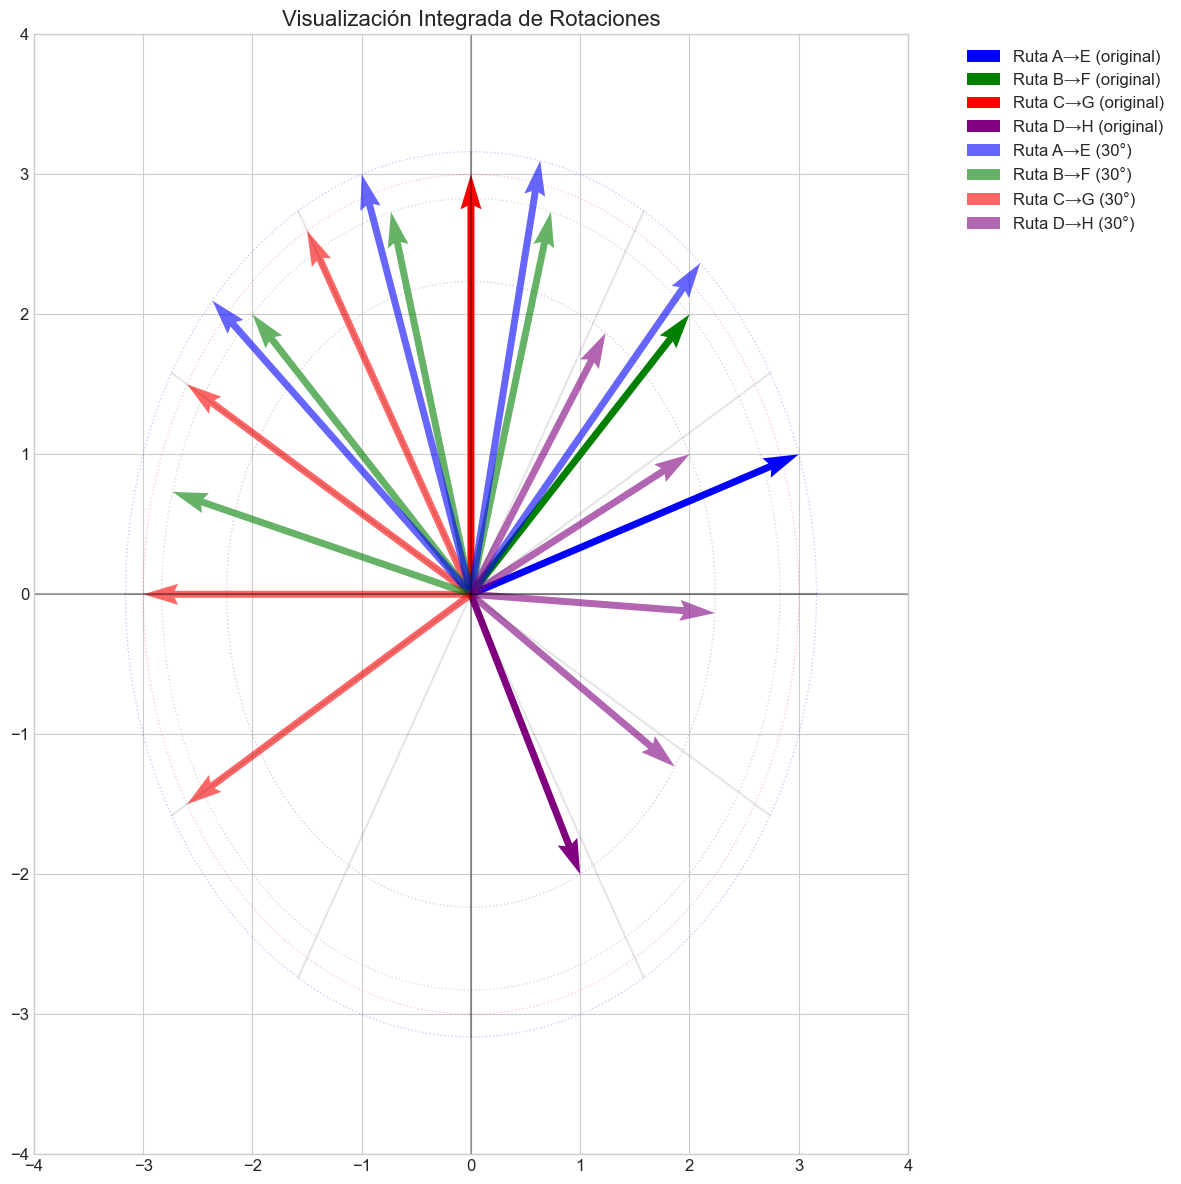

Tabla de coordenadas para todas las rotaciones:
     Vector     Original          30°          60°          90°          120°
0  Ruta A→E   (3.0, 1.0)   (2.1, 2.4)   (0.6, 3.1)  (-1.0, 3.0)   (-2.4, 2.1)
1  Ruta B→F   (2.0, 2.0)   (0.7, 2.7)  (-0.7, 2.7)  (-2.0, 2.0)   (-2.7, 0.7)
2  Ruta C→G   (0.0, 3.0)  (-1.5, 2.6)  (-2.6, 1.5)  (-3.0, 0.0)  (-2.6, -1.5)
3  Ruta D→H  (1.0, -2.0)  (1.9, -1.2)  (2.2, -0.1)   (2.0, 1.0)    (1.2, 1.9)


In [42]:
# Visualización conjunta de todas las rotaciones en un solo gráfico
plt.figure(figsize=(12, 12))
colores = ['blue', 'green', 'red', 'purple']
estilos = ['-', '--', '-.', ':']

# Dibujamos circunferencias para mostrar la trayectoria completa de rotación
for i, v in enumerate(vectores):
    radio = np.linalg.norm(v)
    circulo = plt.Circle((0, 0), radio, fill=False, linestyle=':', color=colores[i], alpha=0.2)
    plt.gca().add_patch(circulo)

# Graficamos los vectores originales
for i, (v, nombre) in enumerate(zip(vectores, nombres_vectores)):
    plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, 
               color=colores[i], label=f"{nombre} (original)", width=0.008)

# Graficamos los vectores rotados para todos los ángulos
for j, angulo in enumerate(angulos_rotacion):
    R = matriz_rotacion(angulo)
    vectores_rotados = np.dot(vectores, R.T)
    
    for i, (v, nombre) in enumerate(zip(vectores_rotados, nombres_vectores)):
        if j == 0:  # Solo agregamos etiqueta para el primer ángulo para no saturar la leyenda
            plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, 
                      color=colores[i], alpha=0.6, linestyle=estilos[j], width=0.008,
                      label=f"{nombre} ({angulo}°)")
        else:
            plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, 
                      color=colores[i], alpha=0.6, linestyle=estilos[j], width=0.008)

# Dibujamos líneas desde el origen al círculo para cada ángulo de rotación del primer vector
# Para ilustrar el concepto de rotación
primer_vector = vectores[0]
radio = np.linalg.norm(primer_vector)
for angulo in range(0, 361, 30):
    x = radio * np.cos(np.radians(angulo))
    y = radio * np.sin(np.radians(angulo))
    plt.plot([0, x], [0, y], 'k-', alpha=0.1)

plt.grid(True)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.title('Visualización Integrada de Rotaciones', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Tabla de todas las rotaciones calculadas
print("Tabla de coordenadas para todas las rotaciones:")
tabla_rotaciones = []

for i, (v, nombre) in enumerate(zip(vectores, nombres_vectores)):
    fila = {'Vector': nombre, 'Original': f"({v[0]:.1f}, {v[1]:.1f})"}
    
    for angulo in angulos_rotacion:
        R = matriz_rotacion(angulo)
        v_rotado = np.dot(R, v)
        fila[f'{angulo}°'] = f"({v_rotado[0]:.1f}, {v_rotado[1]:.1f})"
    
    tabla_rotaciones.append(fila)

print(pd.DataFrame(tabla_rotaciones))

### Aplicación a la red

C:\Users\usuario\AppData\Local\Temp\ipykernel_14324\1767830482.py:46: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G_alternativo, pos={**posiciones, **nuevas_posiciones_rotadas},
C:\Users\usuario\AppData\Local\Temp\ipykernel_14324\1767830482.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


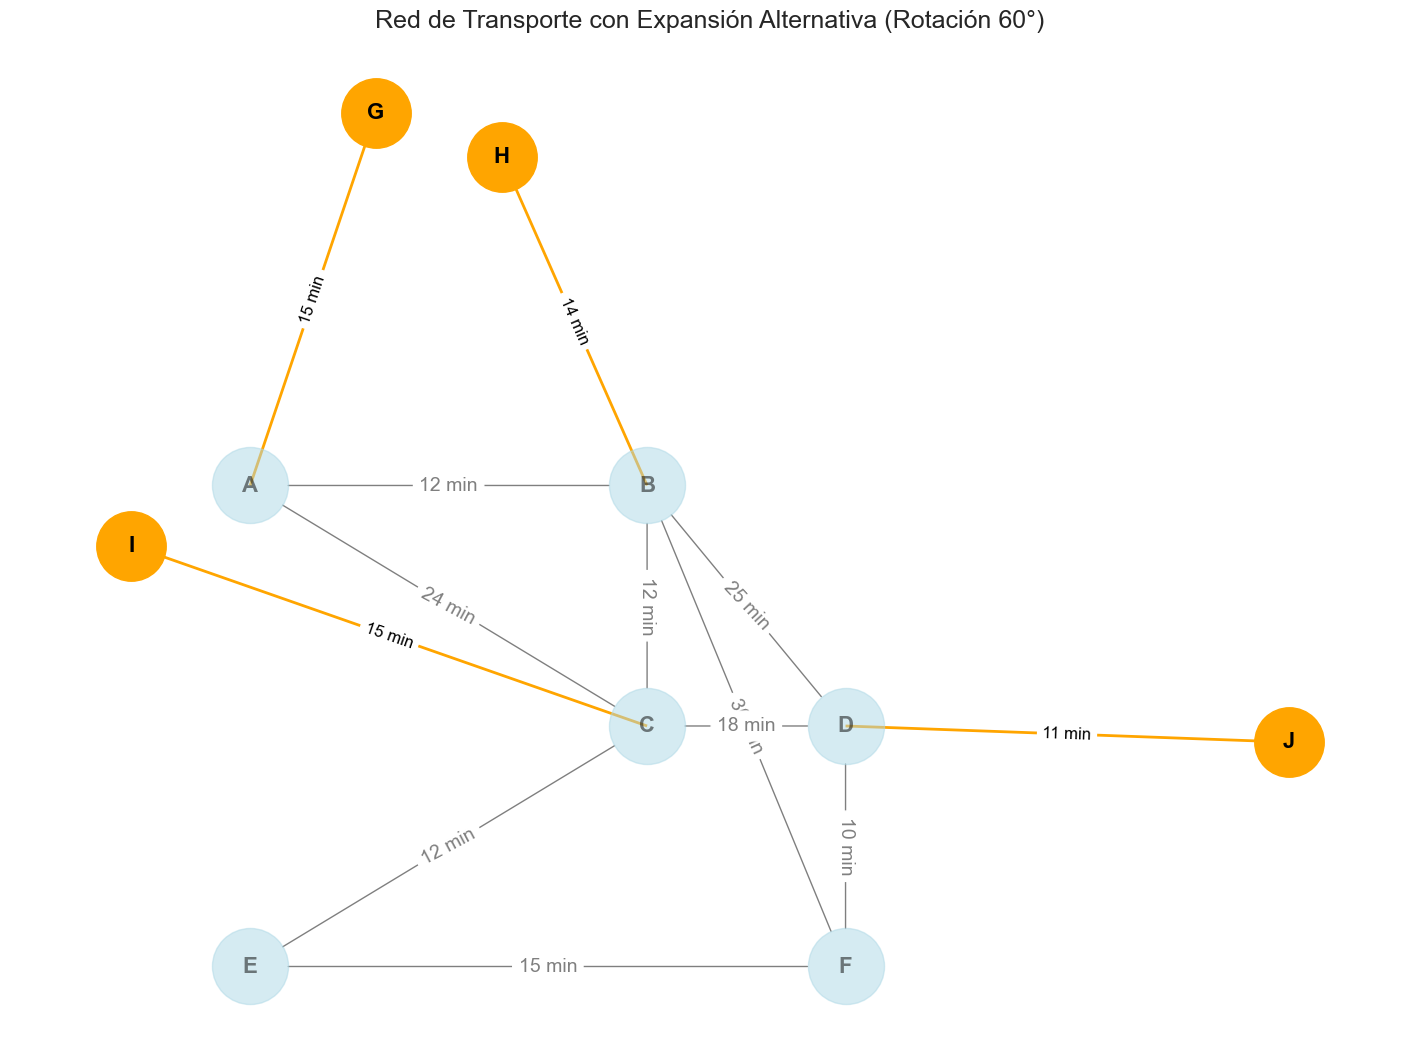

Comparación entre expansión original y alternativa (rotación 60°):

Tiempos de viaje en la expansión original:
• De A a G: 15 minutos
• De B a H: 14 minutos
• De C a I: 15 minutos
• De D a J: 11 minutos

Tiempos de viaje en la expansión alternativa:
• De A a G: 15 minutos
• De B a H: 14 minutos
• De C a I: 15 minutos
• De D a J: 11 minutos

Distribución espacial de las estaciones:
• Original: Más concentrada en el cuadrante nordeste
• Alternativa (rotación 60°): Mejor distribución circular alrededor de las estaciones existentes


In [43]:
# Evaluamos una configuración alternativa usando vectores rotados
angulo_seleccionado = 60  # Seleccionamos la rotación de 60 grados
R = matriz_rotacion(angulo_seleccionado)
vectores_rotados = np.dot(vectores, R.T)

plt.figure(figsize=(14, 10))

# Dibujamos la red original
nx.draw(G, pos=posiciones, with_labels=True, node_size=3000, node_color='lightblue', 
        font_size=16, font_weight='bold', arrowsize=20, arrows=True, alpha=0.5)
nx.draw_networkx_edge_labels(G, pos=posiciones, edge_labels=edges_labels, font_size=14, alpha=0.5)

# Definimos las nuevas estaciones y sus estaciones de origen
nuevas_estaciones = ['G', 'H', 'I', 'J']  # Nombres de las nuevas estaciones
estaciones_origen = ['A', 'B', 'C', 'D']  # Estaciones existentes desde las cuales se expanden

# Calculamos las posiciones de las nuevas estaciones usando los vectores rotados
nuevas_posiciones_rotadas = {}
for i, (vector, nueva_est, origen) in enumerate(zip(vectores_rotados, nuevas_estaciones, estaciones_origen)):
    nuevas_posiciones_rotadas[nueva_est] = (posiciones[origen][0] + vector[0], 
                                            posiciones[origen][1] + vector[1])

# Añadimos las nuevas estaciones y conexiones a un nuevo grafo
G_alternativo = G.copy()
G_alternativo.add_nodes_from(nuevas_estaciones)

# Añadimos las nuevas conexiones
for origen, destino in zip(estaciones_origen, nuevas_estaciones):
    # Calculamos la distancia del vector como tiempo de viaje estimado
    vector = np.array([nuevas_posiciones_rotadas[destino][0] - posiciones[origen][0],
                        nuevas_posiciones_rotadas[destino][1] - posiciones[origen][1]])
    tiempo = np.linalg.norm(vector) * 5  # Suponemos 5 minutos por unidad de distancia
    G_alternativo.add_edge(origen, destino, tiempo=int(tiempo))

# Dibujamos las nuevas estaciones y conexiones
nx.draw_networkx_nodes(G_alternativo, pos={**posiciones, **nuevas_posiciones_rotadas}, 
                      nodelist=nuevas_estaciones, node_size=2500, 
                      node_color='orange', alpha=1)
nx.draw_networkx_labels(G_alternativo, pos={**posiciones, **nuevas_posiciones_rotadas},
                        labels={n: n for n in nuevas_estaciones}, font_size=16, font_weight='bold')

# Dibujamos las nuevas conexiones
edge_nuevos = {(u, v): f"{G_alternativo[u][v]['tiempo']} min" 
               for u, v in G_alternativo.edges() 
               if v in nuevas_estaciones}
nx.draw_networkx_edges(G_alternativo, pos={**posiciones, **nuevas_posiciones_rotadas},
                       edgelist=edge_nuevos.keys(), width=2, alpha=1, 
                       edge_color='orange', connectionstyle='arc3,rad=0.1')
nx.draw_networkx_edge_labels(G_alternativo, pos={**posiciones, **nuevas_posiciones_rotadas},
                            edge_labels=edge_nuevos, font_size=12)

plt.title(f"Red de Transporte con Expansión Alternativa (Rotación {angulo_seleccionado}°)", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

# Comparamos las dos configuraciones de expansión
print(f"Comparación entre expansión original y alternativa (rotación {angulo_seleccionado}°):")
print("\nTiempos de viaje en la expansión original:")
for u, v, datos in G_alternativo.edges(data=True):  # Assuming G_alternativo is the intended graph
    if v in nuevas_estaciones:
        print(f"• De {u} a {v}: {datos['tiempo']} minutos")

print("\nTiempos de viaje en la expansión alternativa:")
for u, v, datos in G_alternativo.edges(data=True):
    if v in nuevas_estaciones:
        print(f"• De {u} a {v}: {datos['tiempo']} minutos")

# Analizar la cobertura espacial de las dos expansiones
print("\nDistribución espacial de las estaciones:")
print("• Original: Más concentrada en el cuadrante nordeste")
print(f"• Alternativa (rotación {angulo_seleccionado}°): Mejor distribución circular alrededor de las estaciones existentes")

**Análisis del Resultado**

La visualización de la red expandida muestra:

- Las estaciones originales (A, B, C, D) en azul claro

- Las nuevas estaciones propuestas (E, F, G, H) en verde claro

- Las nuevas conexiones con sus tiempos de viaje estimados

- Cómo la red se expande siguiendo los vectores de expansión definidos

Esta representación ayuda a los planificadores de transporte a visualizar el impacto potencial de añadir nuevas estaciones, así como a estimar los tiempos de viaje adicionales.